In [1]:
import xarray as xr
import pandas as pd
import os
import noaa_csl_funcs as ncf
import pyproj
import numpy as np
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import salem


# Loading Base Data

In [26]:
def listdir_visible(path):
    '''Function to list only "visible" files/folders (not starting with a period)
    
    Args:
    path (str) : the filepath to list elements of
    
    Returns:
    vis_list (list) : list of files within the input path not starting with a period
    '''
    
    vis_list = [f for f in os.listdir(path) if not f.startswith('.')]
    return vis_list

class Base_CSL_Handler:
    '''This class is built to handle the file storage and naming conventions for the "base" NOAA CSL inventory data, as downloaded and 
    orgainized using data_download.py. These are the raw netcdf files obtained from the NOAA servers'''
    
    def __init__(self,base_data_storage_path,bau_or_covid):
        self.base_data_storage_path = base_data_storage_path #location of the base data directory
        if bau_or_covid not in ['BAU','COVID']: #define if you want to use "business as usual" or "covid" for 2020 traffic data
            raise ValueError('The bau_or_covid input must be one of "BAU" or "COVID"')
        self.bau_or_covid = bau_or_covid

    def load_fullday_nc(self,full_sector,year,month,day_type,chunks = {}):
        '''Loads a full day of data from two 12-hour nc files in a day folder
        
        Args:
        full_sector (str) : name of the sector (like area_OG)
        year (int) : int or string of year
        month (int) : integer month
        day_type (str) : either "satdy", "sundy", or weekdy
        chunks (dict) : a dictionary defining chunks to use in dask. defaults to no chunks, example chunks = {'Time':1}
        
        Returns:
        full_ds (xarray.DataSet) : xarray dataset concatenated on the "utc_hour" dimension for both 00 and 12 day halves
        '''

        ds_00 = self.load_fmt_single_nc(full_sector,year,month,day_type,'00',chunks=chunks) #load the first half
        ds_12 = self.load_fmt_single_nc(full_sector,year,month,day_type,'12',chunks=chunks) #load the second half
        full_ds = xr.concat([ds_00,ds_12],dim = 'utc_hour',data_vars = 'minimal') #combine them
        return full_ds

    def load_fmt_single_nc(self,full_sector,year,month,day_type,hour_start,chunks={}):
        '''Loads and formats a single nc file into an xarray dataset
        
        Args:
        full_sector (str) : name of the sector (like area_OG)
        year (int) : int or string of year
        month (int) : integer month
        day_type (str) : either "satdy", "sundy", or weekdy
        hour_start (str) : either "00" for file starting at 0utc or "12" for file starting at 12utc
        chunks (dict) : a dictionary defining chunks to use in dask. defaults to no chunks, example chunks = {'Time':1}

        Returns:
        ds (xarray.DataSet) : the loaded and formatted dataset for the single nc file        
        '''

        nc_fpath = self.get_full_fname(full_sector,year,month,day_type,hour_start) #get the full path of the nc file
        ds = xr.open_dataset(nc_fpath,chunks=chunks) #open the dataset with one time chunk

        #Define attributes from the loaded file that aren't natively in the nc metatdata
        if full_sector.startswith('area'):
            grid_type = 'area'
        elif full_sector.startswith('point'):
            grid_type = 'point'
        else:
            raise ValueError(f'The input {full_sector} for full_sector does not start with "area" or "point". Something wrong here.')
        sector_id = '_'.join(full_sector.split('_')[1:]) #the full_sector without the "point" or "area" prepend
        
        #set the attributes
        ds.attrs['grid_type'] = grid_type
        ds.attrs['sector_id'] = sector_id
        ds.attrs['year'] = year
        ds.attrs['month'] = month
        ds.attrs['day_type'] = day_type
        ds.attrs['nc_fpath'] = nc_fpath
        if (year == 2020) & (sector_id in ['onroad_gasoline','onroad_diesel','offroad']): #if it's covid changable, add the attr
            ds.attrs['bau_or_covid'] = self.bau_or_covid

        #Deal with time dimension
        new_timedim_name = 'utc_hour' #new name of time dimension for clarity
        ds = self.rename_timedim(ds,newname=new_timedim_name) #rename the time dimension
        if hour_start == '12': #if it's a "12z" file, need to add 12 to the time dimension as when loaded, they are [0:12] (indicating hours since 12). 
            ds[new_timedim_name] = ds[new_timedim_name]+12
        else: #if its a '00' file, the indicies are correct and 0 = 00 hours , 1 = 01 hours etc. 
            ds[new_timedim_name] = ds[new_timedim_name]

        #In some of the sectors, there is an unkown datavariable called "Times" which is confusing. I just delete it if it's there. 
        if 'Times' in list(ds.data_vars):
            ds = ds.drop_vars('Times')

        for data_var in list(ds.data_vars.keys()): #for all of the data variables
            ds[data_var].attrs['units'] = ds[data_var].attrs['units'] + ' gridcell^-1' #add ' gridcell^-1' to the units for clarity. all NOAA CSL base data is absolute unites i.e. "per gridcell"
        
        return ds

    def get_full_fname(self,full_sector,year,month,day_type,hour_start):
        '''Gets the full path and filename for a given base data file
        
        Args:
        full_sector (str) : name of the sector (like area_OG)
        year (int) : int or string of year
        month (int) : integer month
        day_type (str) : either "satdy", "sundy", or weekdy
        hour_start (str) : either "00" for file starting at 0utc or "12" for file starting at 12utc
        
        Returns:
        day_fullpath (str) : full path to the data file defined by the inputs. If no files, returns None
        '''

        year_str = self.yr_to_yrstr(full_sector,year) #make the year a string
        month_str = ncf.month_int_to_str(month) #make the month a string of the form "MonthXX"
        day_folder = os.path.join(self.base_data_storage_path,full_sector,year_str,month_str,day_type) #get the day folder
        day_files = self.list_day_files(day_folder) #list all the files in the day folder
        for day_fname in day_files: #loop through files
            day_fullpath = os.path.join(day_folder,day_fname) #get the full path
            if self.hour_matches(day_fname,hour_start): #if the file matches the hour, that's the one we want
                return day_fullpath #so return it
            else: #otherwise
                continue #keep looping through the files in the day folder
        print("No matching files found") #if it gets here, there were no files that matched all of the input parameters
        return None #so we return none

    def yr_to_yrstr(self,sector,year):
        '''Converts a year to a string, and adds "COVID" or "BAU" to onroad/offroad data for 2020
        
        Args:
        sector (str) : the sector string (example = area_OG)
        year (int) : the year integer
        
        Returns:
        year_str (str) : the year in string format and bau or covid if needed
        '''

        if sector not in ['area_onroad_gasoline','area_onroad_diesel','area_offroad']: #if it's not an onroad/offroad source, no bau or covid
            return str(year) #so just return the string of the int
        if year == 2020: #if it's 2020, there is a covid option for onroad/offroad
            year_str = str(year)+self.bau_or_covid #use the input bau_or_covid variable to get correct string of form 2020COVID or 2020BAU
        else:#if it's not 2020
            year_str = str(year) #just use the year string 
        return year_str
    
    def hour_matches(self,fname,hour_start):
        '''Check that the hour start matches in the filename
        
        Args:
        fname (str) : the name of the file (not the full path)
        hour_start (str) : the hour start to check if it is in the file
        
        Returns:
        (bool) : True if the hour start is found in the fname, false if not
        '''

        split_fname = fname.split('_') #split the fname by underscore
        fname_hr = split_fname[1][0:2] #the first two characters of the split filename's second element is the hour in the filename
        if fname_hr not in ['00','12']: #it should be one of these two
            print(fname,fname_hr) #if it isnt, print it and raise an error
            raise ValueError('The "start hour" in the filename should be "00" or "12" -- something went wrong here')
        if hour_start == fname_hr: #ir the hour start matches
            return True #return true
        else: #otherwise
            return False #return false
        
    def list_day_files(self,day_folder):
        '''Lists the files in a day folder and checks that there are the right number (2)
        
        Args: 
        day_folder (str) : full filepath to the "day" folder (ex ~/data/area_OG/2019/Month01/satdy)
        
        Returns:
        files (list) : list of files in the day folder
        
        Raises:
        Exception : this happens when the number of files in this folder is not 2 -- something may be wrong with the data organizatino
        '''
        
        files = os.listdir(day_folder) #lists the files in the folder
        if len(files)!=2: #check that there are exactly two
            raise Exception(f'There are more than 2 nc files in {day_folder}. Something might be wrong here')
        return files
    
    def rename_timedim(self,ds,newname = 'utc_hour'):
        '''Renames the time dimension
        
        Args:
        ds (xarray.DataSet) : an xarray dataset with a time dimension
        newname (str, optional) : the new name of the time dimension. defaults to 'utc_hour' as defined in base data
        
        Returns:
        ds (xarray.DataSet) : the xarray dataset with the changed time dimension
        '''

        og_time_dim = self.get_og_timedim_name(ds) #get the original name of the time dimension in the dataset (they can differ so need a function)
        ds = ds.rename_dims({og_time_dim:newname}) #rename the time dimension from the original to the new
        return ds

    def get_og_timedim_name(self,ds):
        '''Gets the origial name for the time dimension in a dataset. In different data sets there are different labels for time, so we want to find what it is
        
        Args:
        ds (xarray.DataSet) : the dataset to find the time dimension in 
        
        Returns:
        time_dim (str) : the string name of the time dimension in the input dataset
        
        Rasies:
        ValueError : if there are multiple time dimensions or no time dimensions detected
        '''
         
        dims = list(ds.dims) #list the dims of the dataset
        time_dims = [] #initialize the time dim list 
        for dim in dims: #loop through the dims
            if dim.lower() in ['time','times']: #it could be a combination of Time, Times, time or times
                time_dims.append(dim) #if it fits the criteria, add it to the list
        if len(time_dims) > 1: 
            raise ValueError("There appears to be more than one labeled time dimension in the original dataset")
        elif len(time_dims) == 0:
            raise ValueError("Could not detect a time dimension in the input dataset")
        else:
            time_dim = time_dims[0] #should be the only one
        return time_dim

base_data_storage_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data' #where the data downloaded using data_download.py lives


## Testing

In [10]:
#Check that each day has only two nc files
for sector in listdir_visible(base_data_storage_path):
    # if not sector in ['area_onroad_diesel','area_onroad_gasoline','area_offroad','area_OG']:
    #     continue
    sector_path = os.path.join(base_data_storage_path,sector)
    for year in ['2019','2020','2021']:
        year_path = os.path.join(sector_path,year)
        for month in ['Month01','Month02','Month03','Month04','Month05','Month06','Month07','Month08','Month09','Month10','Month11','Month12']:
            month_path = os.path.join(year_path,month)
            for day_type in listdir_visible(month_path):
                if day_type not in ['satdy','sundy','weekdy']:
                    print(month_path,day_type)
                    continue
                day_path = os.path.join(month_path,day_type)
                files_list = os.listdir(day_path)
                num_files = len(files_list)
                if num_files != 2:
                    print(day_path)                    


/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month01 fuel_scalings.csv
/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month01 fuel_avg.nc
/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month02 fuel_scalings.csv
/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month02 fuel_avg.nc
/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month03 fuel_scalings.csv
/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month03 fuel_avg.nc
/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month04 fuel_scalings.csv
/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month04 fuel_avg.nc
/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2019/Month05 fuel_scalings.csv
/uufs/c

FileNotFoundError: [Errno 2] No such file or directory: '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/area_onroad_gasoline/2020/Month01'

In [34]:
bau_or_covid = 'COVID'
full_sector = 'point_EGU'
year = 2019
month = 10
day_type = 'satdy'
hour_start = '12'

BCH = Base_CSL_Handler(base_data_storage_path,bau_or_covid)
#nc_fpath = BCH.get_full_fname(full_sector,year,month,day_type,'00')
#ds = xr.load_dataset(nc_fpath,chunks={'Time':1})

ds = BCH.load_fullday_nc(full_sector,year,month,day_type)

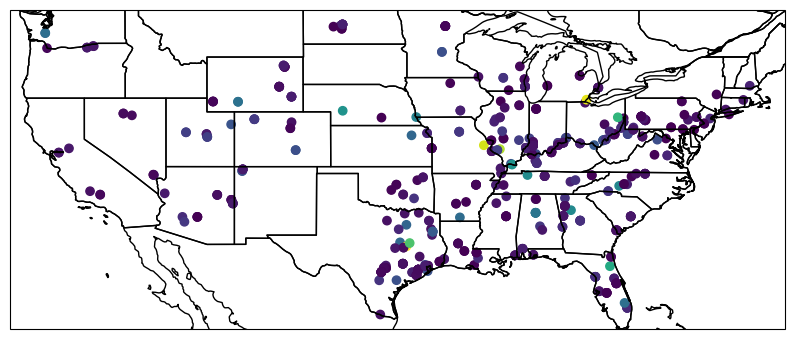

In [37]:
df = ds['CO2'][1].to_dataframe()
sub_df = df.loc[df['CO2']>100]

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
ax.scatter(sub_df['XLONG'],sub_df['XLAT'],c=sub_df['CO2'])
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()

# Regridding

https://medium.com/pangeo/changing-the-way-you-look-at-earth-data-with-xesmf-ee55d0b380e5     
https://fabienmaussion.info/2018/01/06/wrf-projection/

In [18]:
bau_or_covid = 'COVID'
full_sector = 'area_Industry'
year = 2020
month = 1
day_type = 'weekdy'

BCH = Base_CSL_Handler(base_data_storage_path,bau_or_covid)
ds = BCH.load_fullday_nc(full_sector,year,month,day_type)#,chunks={'Time':1})

In [19]:
class CSL_Unit_Converter:
    '''
    Class to handle unit conversino in the CSL datasets. Should work on both "base" data (prior to regridding), and "regridded" data. Since
    we need to convert absolute units (per gridcell) to standard m^-2 before regridding, this is used prior to regridding. It can also be used
    after regridding to convert mass and time units
    '''

    def __init__(self,species_details_fullpath):
        #self.species_details = self.load_species_details(species_details_fullpath)
        pass

    def absolute_to_flux(self,ds,species_list = 'all',grid_cell_area = 16000000,drop_species = True):
        '''Converts from absolute uints (per grid cell) to flux units (per meter^2)
        
        Args:
        ds (xr.DataSet): an xarray dataset with absolute units (per grid cell)
        species_list (str, list) : a list of species (data_vars) in the ds that you want to convert. defaults to 'all' 
        grid_cell_area (int) : the area in meters^2 of a grid cell. For NOAA CSL area emissions, in Lambert Conformal, the grid cells are 
                                approximately 4km x 4km = 4000m x 4000m = 16000000m^2
        drop_species (bool) : True if you want only the input species_list to be returned in the ds, if false, will return all species with only the species_list ones converted
        
        Returns:
        ds (xr.DataSet): an xarray dataset with flux units (meter^-2)
        '''

        if species_list == 'all': # if we want to convert all the variables
            species_list = self.get_data_vars(ds) #set the species list to the entire list of data_vars
        if species_list == None: #if there is no species, it's probably a data array instead of a dataset. 
            raise TypeError('Input was likely a data array not a dataset. Need a dataset.')
        
        out_ds = ds.copy() #use the original dataset as the starting point
        for species in species_list: #loop through all of the species to convert
            old_unit_list = self.unit_finder(ds[species]) #find the old units of the species
            if 'gridcell^-1' not in old_unit_list: #if there arene units of gridcell^-1, this unit conversion shouldn't be done!
                raise ValueError(f'The dataset did not have units in gridcell^-1 for species {species}')
            
            out_ds[species] = out_ds[species]/grid_cell_area #key step, divide each value by the grid cell area in m^2 to get to m^-2

            out_ds[species].attrs = ds[species].attrs #keep the attributes
            new_units = self.unit_replacer(old_unit_list,'gridcell^-1','meters^-2') #find the new units 
            out_ds[species].attrs['units'] = new_units #replace the units attribute with the new units
        if drop_species: #if you wanted to only get the species you converted
            out_ds = out_ds[species_list] #subset to them
        return out_ds
    
    def mass_conversion(self,ds,from_unit='metric_Ton',to_unit='grams'):
        '''Converts between units of mass
        
        Args:
        ds (xr.DataSet): an xarray dataset with an attribute "units" that has a mass element
        from_unit (str): the unit to convert from
        to_unit (str): the unit to convert to
        
        Returns:
        ds (xr.DataSet): an xarray dataset with units of grams
        '''

        mass_unit_to_grams= {
            'metric_Ton':1E6,
            'kilograms':1E3
        }
        
        unit_list = self.unit_finder(ds)
        if from_unit not in unit_list:
            raise ValueError(f'Trying to convert metric_Ton to grams, but no {from_unit} in units attribute')
        if from_unit not in list(mass_unit_to_grams.keys()):
            raise ValueError(f'Could not find {from_unit} in conversion dictionary -- options are {list(mass_unit_to_grams.keys)}')
        if to_unit not in ['grams'].extend(list(mass_unit_to_grams.keys())):
            raise ValueError(f'Could not find to_unit={to_unit} in the conversion dictionary -- options are {list(mass_unit_to_grams.keys)})')
        

        gram_converter = mass_unit_to_grams[from_unit]
        if to_unit == 'grams':
            out_converter = gram_converter
        else:
            out_converter = gram_converter/mass_unit_to_grams[to_unit]
        return ds * gram_converter
    
    def perhr_to_persec(self,ds):
        '''Converts from uints per hour to units per second
        
        Args:
        ds (xr.DataSet): an xarray dataset with units in unit/hour
        
        Returns:
        ds (xr.DataSet): an xarray dataset with unit/second
        '''
        
        s_per_h = 3600
        return ds/s_per_h
    
    def unit_finder(self,da):
        '''Finds the units of a data array
        
        Args:
        da (xarray.DataArray) : the data array to find the units of 
        
        Returns:
        unit_list (list) : the units in list form, each unit is its own element
        '''

        unit_string = da.attrs['units'] #get the units from the attributes
        unit_list = unit_string.split() #split it on spaces
        return unit_list
    
    def unit_replacer(self,unit_list,from_unit,to_unit):
        '''Replace a unit in the unit_list with desired new unit
        
        Args:
        unit_list (list) : units in list form
        from_unit (str) : the unit to be replaced
        to_unit (str) : the new unit string to be put in
        
        Returns:
        new_units (str) : the new units, in string form
        '''

        if from_unit not in unit_list:
            raise ValueError(f'from_unit ({from_unit}) is not in the unit list ({unit_list})')

        new_unit_list = [] #initialize the new units list
        for unit in unit_list: #loop through units
            if unit == from_unit: #if the unit matches the from unit
                new_unit_list.append(to_unit) #replace it with the to_unit
            else: #otherwise it isnt the from_unit
                new_unit_list.append(unit) #so keep it the same
        new_units = ' '.join(new_unit_list) #join them on space to get the string
        return new_units
    
    def get_data_vars(self,ds):
        '''Gets a list of the data variables in a dataset 
        
        Args: 
        ds (xarray.DataSet): xarray dataset we want to find the data variables of 
        
        Returns:
        data_var_list (list) : a list of strings representing the data_vars of ds
        '''

        data_var_list = list(ds.data_vars.keys())
        return data_var_list



In [20]:
unit_converter = CSL_Unit_Converter()
ds_flx = unit_converter.absolute_to_flux(ds)

In [21]:
class RegridInputs:
    '''A class to hold the inputs for the CSL regridder. These are the defaults.'''

    grid_out = {  
    'lat': np.arange(19, 58, 0.1), #Center Point Spacing Lat
    'lon': np.arange(-138, -59, 0.1), #Center Point Spacing Lon
    'lat_b': np.arange(18.95, 58.05, 0.1), # Boundary Spacing Lat 
    'lon_b': np.arange(-138.05, -58.95, 0.1), # Boundary Spacing Lon
    }
    method = 'conservative'
    input_dims=('south_north','west_east')
    weights_path = '/uufs/chpc.utah.edu/common/home/u0890904/NOAA_CSL/noaa_csl/regridding/saved_weights'

class CSL_Regridder:
    '''A class to regrid the noaa_csl base data from lambert conformal coordinates into latitude/longitude coordinates'''

    def __init__(self,regrid_inputs):
        ''' 
        Args: 
        regrid_inputs (inst RegridInputs) : an instance of the RegridInputs class
        '''

        self.inputs = regrid_inputs

    def save_regrid_weights(self,regridder,save_path=None,fname=None):
        '''Saves the regridded weights to a file
        
        Args:
        regridder (xe.Regridder) : an instance of the regridder class to save
        save_path (str, optional) : the path in which to store the weights. defaults to the inputs.weights_path
        fname (str, optional) : the name of the saved weights file. defaults to a filename based on attributes of the dataset
        '''

        if save_path is None:
            save_path = self.inputs.weights_path
        
        if fname is None:
            fname = f'lcc_to_latlon_{regridder.ds_attrs['sector_id']}_{regridder.ds_attrs['year']}_{regridder.ds_attrs['month']}_{regridder.ds_attrs['day_type']}.nc'
        
        regridder.to_netcdf(os.path.join(save_path,fname))

    def create_regridder(self,ds,weightsfile_or_create='create',**kwargs):
        '''Creates the regridder object that can be used to regrid datasets
        
        Args:
        ds (xarray.DataSet) : the input dataset to use for the "in_grid". this should be "base" data
        weightsfile_or_create (str, optional) : if 'create', the weights in the regridder will be created using the grid_in and grid_out. If this variable
                                                is a full filepath, it will use that filepath as the saved weights instead of creating anew
        **kwargs : can override using self.inputs by adding a keyword arg matching the xe.Regridder (grid_out,method,input_dims)
        '''

        grid_in = self.create_ingrid(ds) #create the input grid from the dataset
        grid_out = self.kwargs_or_inputs(kwargs,'grid_out') #get the grid out from kwargs first then inputs
        method = self.kwargs_or_inputs(kwargs,'method') #get the method from kwargs first then inputs
        input_dims = self.kwargs_or_inputs(kwargs,'input_dims') #get the input dims from kwargs firs then inputs
        if weightsfile_or_create == 'create': #if we're creating it from the in and out grids 
            regridder = xe.Regridder(grid_in,grid_out,method=method,input_dims=input_dims) #don't reuse weights, and just create it
        else: #if not, we're expecting a filepath 
            weights_path = self.kwargs_or_inputs(kwargs,'weights_path') #path to the weights 
            weights_full_filepath = os.path.join(weights_path,weightsfile_or_create) #full path to the weights file
            if not os.path.isfile(weights_full_filepath): #if there isn't a file there, something went wrong
                raise FileExistsError(f'No weights file found at {weights_full_filepath}')
            
            #otherwise, create the regridder with the saved weights file
            regridder = xe.Regridder(grid_in,grid_out,method=method,input_dims=input_dims,reuse_weights=True,filename=weights_full_filepath)

        regridder.ds_attrs = ds.attrs #add the dataset attributes to the regridder attributes to keep track of things
        return regridder

    def create_ingrid(self,ds):
        '''Creates the grid that will be input into the regridder from a "base" noaa_csl dataset. Adapted from Colin Harkins at NOAA
        
        Args:
        ds (xarray.DataSet) : the xarray dataset to use as the grid_in
        
        Returns:
        grid_in (dict) : a grid_in type dictionary that can be fed to xe.Regridder
        '''

        #create the projection transformers. 'wgs_to_lcc' converts EPSG4326 to lambert conformal, 'lcc_to_wgs' does the opposite
        wgs_to_lcc, lcc_to_wgs = self.create_transformers(ds)  

        # Calculate the easting and northings of the domain center point
        e,n = wgs_to_lcc.transform(ds.CEN_LON, ds.CEN_LAT) #use the attribributes to transform lat lons defined in the ds as center to lcc

        # Grid parameters from the dataset
        dx, dy = ds.DX, ds.DY 
        nx, ny = ds.dims['west_east'], ds.dims['south_north']

        # bottom left corner of the domain
        x0 = -(nx-1) / 2. * dx + e
        y0 = -(ny-1) / 2. * dy + n

        # Calculating the boundary X-Y Coordinates
        x_b, y_b = np.meshgrid(np.arange(nx+1) * dx + x0 -dx/2, np.arange(ny+1) * dy + y0 -dy/2)
        x_bc, y_bc = lcc_to_wgs.transform(x_b, y_b)

        #define the input grid
        grid_in = {
            'lat':ds['XLAT'].values,
            'lon':ds['XLONG'].values,
            'lat_b':y_bc,
            'lon_b':x_bc
        }

        return grid_in

    def create_transformers(self,ds):
        '''Create transformers for going from lambert conformal to WGS and vice versa
        
        Args:
        ds (xarray.dataset) : use the dataset to define the lcc projection, as noaa_csl "base" data is in LCC
        
        Returns:
        wgs_to_lcc (pyproj.Transformer) : a transformer object to transform from WGS coordinates to LCC coordinates
        lcc_to_wgs (pyproj.Transformer) : a transformer object to transform from LCC coordinates to WGS coordinates
        '''

        proj4_str = self.proj4_from_ds(ds) #get the proj4 string from the dataset
        lcc_crs = pyproj.CRS.from_proj4(proj4_str) #define the lcc coordinate reference system using the proj4 string
        wgs_crs = pyproj.CRS.from_epsg(4326) #define wgs coordinates as espg 4326
        wgs_to_lcc = pyproj.Transformer.from_crs(wgs_crs,lcc_crs,always_xy=True) #create one transformer
        lcc_to_wgs = pyproj.Transformer.from_crs(lcc_crs,wgs_crs,always_xy=True) #create the other transformer

        return wgs_to_lcc, lcc_to_wgs

    def proj4_from_ds(self,ds,map_proj=None,earth_rep="sphere"):
        '''Get a proj4 string defining a projection from a noaa_csl "base" dataset 
        
        Args:
        ds (xarray.Dataset) : a dataset to get the projection from
        map_proj (proj,optional) :the pyproj.Proj proj argument. allow the user to directly define the map proj, defaults to getting it from the dataset
        earth_rep (str) : change the earth representation of the input projection TODO, only can do "sphere" right now
        '''
         
        if map_proj == None: #if the user didn't define a map projection
            try: #try it so we can catch bad ones
                if ds.MAP_PROJ_CHAR == 'Lambert Conformal': #teh datasets from noaa_csl "base" data should have the "Lambert Conformal" attribute, so confirm this
                    map_proj = 'lcc' #if so, the map_proj code is lcc
                else: #if not, something unexpected happend
                    raise ValueError(f"Unknown map projection in ds.MAP_PROJ_CHAR: {ds.MAP_PROJ_CHAR}")
            except: #if it failed, something weird happened
                raise Exception('No map projection found')
            
        if earth_rep == 'sphere': #can only do spheres for now. this is how the noaa_csl "base" data is represented (like WRF) see references
            my_proj = pyproj.Proj(proj=map_proj, # projection type: Lambert Conformal Conic
                                lat_1=ds.TRUELAT1, lat_2=ds.TRUELAT2, # Cone intersects with the sphere
                                lat_0=ds.MOAD_CEN_LAT, lon_0=ds.STAND_LON, # Center point
                                a=6370000, b=6370000) # The Earth is a perfect sphere
        else:
            raise Exception("Haven't dealt with non spheres yet")
        
        return my_proj.to_proj4()
    
    def kwargs_or_inputs(self,kwargs,key):
        '''Get a value from either a dict of keyword arguments as preference, or if not use self.inputs
        
        Args:
        kwargs (dict) : keyword arguments
        key (str) : the key to extract the value of
        
        Returns:
        value : the value prioritizing kwargs, if not self.inputs
        '''
        
        if key in list(kwargs.keys()):
            return kwargs[key]
        else:
            return getattr(self.inputs,key)



/uufs/chpc.utah.edu/common/home/u0890904/NOAA_CSL/noaa_csl/regridding/saved_weights/lcc_to_latlon_OG_2019_1_weekdy.nc


In [ ]:
regrid_weights_path = '/uufs/chpc.utah.edu/common/home/u0890904/NOAA_CSL/noaa_csl/regridding/saved_weights'

inputs = RegridInputs
cr = CSL_Regridder(inputs)

regridder_created = cr.create_regridder(ds_flx)
regridder_loaded = cr.create_regridder(ds_flx,weightsfile_or_create='lcc_to_latlon_OG_2019_1_weekdy.nc')
#cr.save_regrid_weights(regridder)

In [27]:
ds

<xarray.Dataset>
Dimensions:   (utc_hour: 24, south_north: 1008, west_east: 1332)
Coordinates:
    XLAT      (south_north, west_east) float32 18.19 18.2 18.21 ... 52.42 52.41
    XLONG     (south_north, west_east) float32 -121.8 -121.7 ... -58.63 -58.58
  * utc_hour  (utc_hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Dimensions without coordinates: south_north, west_east
Data variables: (12/95)
    HC54      (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    HC55      (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    HC56      (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    HC57      (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    HC58      (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    HC59      (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    ...        ...
    PM14      (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    PM15      (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    PM16      (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    PM17      (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    PM18      (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
    PM19      (utc_hour, south_north, west_east) float32 dask.array<chunksize=(12, 1008, 1332), meta=np.ndarray>
Attributes: (12/35)
    WEST-EAST_GRID_DIMENSION:        1333
    SOUTH-NORTH_GRID_DIMENSION:      1009
    DX:                              4000.0
    DY:                              4000.0
    WEST-EAST_PATCH_START_UNSTAG:    1
    WEST-EAST_PATCH_END_UNSTAG:      1332
    ...                              ...
    grid_type:                       area
    sector_id:                       Industry
    year:                            2020
    month:                           1
    day_type:                        weekdy
    nc_fpath:                        /uufs/chpc.utah.edu/common/home/lin-grou...

In [22]:
regridded_ds_created = regridder_created(ds_flx,keep_attrs=True)
regridded_ds_loaded= regridder_loaded(ds_flx,keep_attrs=True)

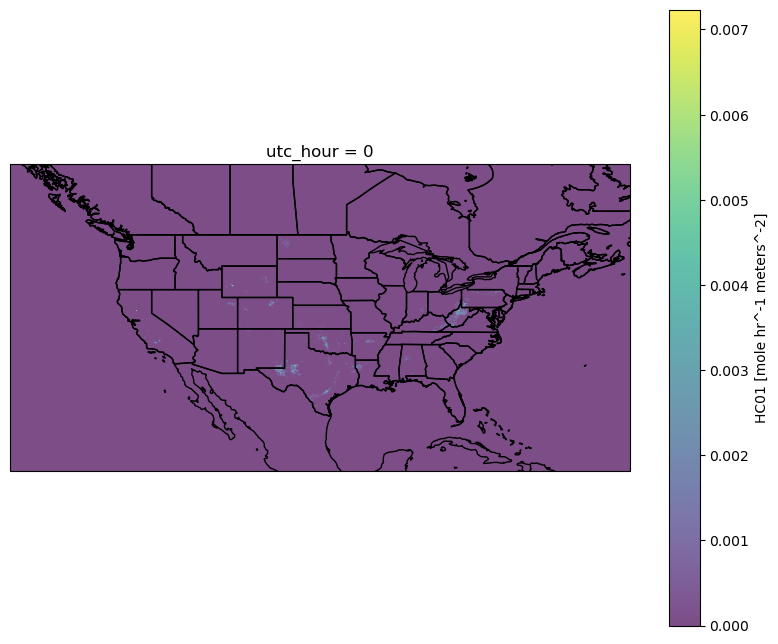

In [11]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
regridded_ds['HC01'][0,:,:].plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()

## Colin initial

In [13]:
class inputs():
    # Define all variables related to input and output and regions
    # File names to read in
    # fn_base1 = 'wrfchemi_00z_d01'
    # fn_base2 = 'wrfchemi_12z_d01'
    # fn_ext = '.nc'
    
    # file name for save out
    # fn_out = 'regridded.nc'
    
    # input_dir = '/data/colharkins/EI_noaa/VCP/VCP_EI/'
    # out_dir = '/data/colharkins/EI_noaa/VCP/VCP_EI/'
    # base_dir = '/data/colharkins/EI_noaa/VCP/VCP_EI/'
    
    # days = ['weekdy','satdy','sundy']
    # years = [2011]
    # months = {'Month01':1,'Month02':2,
    #     'Month03':3,'Month04':4,
    #     'Month05':5,'Month06':6,
    #     'Month07':7,'Month08':8,
    #     'Month09':9,'Month10':10,
    #     'Month11':11,'Month12':12}

    # Converting Everything into kg/m^2/hour 
    MW = {'E_ALD': 44.05, 'E_CH4': 16,'E_CO' : 28,'E_CO2' : 44,'E_CSL' : 106.16,'E_ETH' : 28.05,
             'E_HC3': 44.1,'E_HC5' : 58.12,'E_HC8' : 58.12,'E_HCHO' : 30.031, 'E_HONO': 47, 'E_ISO': 68.12,
             'E_KET': 58.08, 'E_NH3': 17, 'E_NO': 30.01, 'E_NO2': 46.0055, 'E_OL2': 28.05, 'E_OLI': 42.08,
             'E_OLT' : 42.08,'E_ORA2': 74.08, 'E_SO2': 64, 'E_TERP': 136.23,'E_TOL': 92.14, 'E_UNID': 128.18,'E_XYL': 106.16}
    
    Aerosols = ['E_EC', 'E_NO3', 'E_ORG', 'E_PM25', 'E_PM10', 'E_SO4']
    
    reuse_weight_file = False

In [14]:
# Courtesy of Colin Harkins @ NOAA
def makeregridder(ds,var_name):
    #Calculating Projection from WRF LCC to WRF lat long space 
    wrf_proj = pyproj.Proj(proj='lcc', # projection type: Lambert Conformal Conic
                           lat_1=ds.TRUELAT1, lat_2=ds.TRUELAT2, # Cone intersects with the sphere
                           lat_0=ds.MOAD_CEN_LAT, lon_0=ds.STAND_LON, # Center point
                           a=6370000, b=6370000) # This is it! The Earth is a perfect sphere
    
    # Calculating the Projection from WRF lat long to WGS lat long
    # Easting and Northings of the domains center point
    wgs_proj = pyproj.Proj(proj='latlong', datum='WGS84')
    e, n = pyproj.transform(wgs_proj, wrf_proj, ds.CEN_LON, ds.CEN_LAT)
    
    # Grid parameters
    dx, dy = ds.DX, ds.DY
    nx, ny = ds.dims['west_east'], ds.dims['south_north']
    # Down left corner of the domain
    x0 = -(nx-1) / 2. * dx + e
    y0 = -(ny-1) / 2. * dy + n

    # 2d grid
    xx, yy = np.meshgrid(np.arange(nx) * dx + x0, np.arange(ny) * dy + y0)
    
    # Calculating the boundary X-Y Coordinates
    x_b, y_b = np.meshgrid(np.arange(nx+1) * dx + x0 -dx/2, np.arange(ny+1) * dy + y0 -dy/2)

    #Transformation of Center X-Y to Center Lat-Lon
    xc, yc = pyproj.transform(wrf_proj, wgs_proj, xx, yy)
    
    #Transformation of Boundary X-Y to Center Lat_Lon
    x_bc, y_bc = pyproj.transform(wrf_proj, wgs_proj, x_b, y_b)
    
    #Pulling out 1 variable to calc transformation with
    dr = ds[var_name][0,:,:]
    dr_int = dr.to_dataset(name=var_name)
    
    #Grid Spacing For prior grid
    in_coords = {'lat': dr_int['XLAT'].values, #Center Point Spacing Lat
                        'lon': dr_int['XLONG'].values, #Center Point Spacing Lon
                        'lat_b': y_bc, # Boundary Spacing Lat 
                        'lon_b': x_bc, # Boundary Spacing Lon
                       }
    
    #Grid Spacing For New Grid
    out_coords = {  'lat': np.arange(23, 54, 0.1), #Center Point Spacing Lat
                    'lon': np.arange(-126, -63, 0.1), #Center Point Spacing Lon
                    'lat_b': np.arange(22.95, 54.05, 0.1), # Boundary Spacing Lat 
                    'lon_b': np.arange(-126.05, -62.95, 0.1), # Boundary Spacing Lon
                }
    out_coords = {  'lat': np.arange(19, 58, 0.1), #Center Point Spacing Lat
                    'lon': np.arange(-138, -59, 0.1), #Center Point Spacing Lon
                    'lat_b': np.arange(18.95, 58.05, 0.1), # Boundary Spacing Lat 
                    'lon_b': np.arange(-138.05, -58.95, 0.1), # Boundary Spacing Lon
                }
    # Constructing Regridder
    regridder = xe.Regridder(in_coords, out_coords, method='conservative',reuse_weights=inputs.reuse_weight_file)
    return regridder, xc, yc


def reformat_ds(ds, lonc, latc):
    # Renaming Files to proper Names, setting coordinates
    ds = ds.rename({'south_north':'y'})
    ds = ds.rename({'west_east':'x'})
    ds = ds.assign({'lat': (['y', 'x'], latc),'lon': (['y', 'x'], lonc)})
    ds = ds.set_coords('lat')
    ds = ds.set_coords('lon')
    ds = ds.set_coords('Times')
    return ds

def convert_units(ds_out):
    ds_out_convert = ds_out
    # Convert other units
    # originally in moles/km^2/hour, converting to kg/m^2/s
    for key in inputs.MW:
        if key not in list(ds_out_convert.keys()):
            continue
        ds_out_convert[key] = ds_out[key]*inputs.MW[key]/3600/1000000/1000 # 1hour/3600s 1m2/1e6km2 1kg/1000g
        
    # convert aerosol units
    #for word in inputs.Aerosols:
    #    ds_out_convert[word] = ds_out[word]/1000000000 # convert from ug/m^3 m/s to kg/m^2/s by * 1e9
    return ds_out_convert
    
# End convert_units

def reformat_ds_out(ds_out_convert,day_half):
    #More formatting to COARDS
    #Renaming Dimentions 
    ds_out_convert = ds_out_convert.rename({'Time':'time'})
    ds_out_convert = ds_out_convert.rename({'Times':'time'})# rename coordinate of time
    
    ## Changing time to be what it should be for 7/4/2018
    #ds_out_convert['time'] = [162216, 162217, 162218, 162219, 162220, 162221, 162222, 162223, 162224, 162225, 162226, 162227]
    if day_half == '00':
        ds_out_convert['time'] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    elif day_half == '12':
        ds_out_convert['time'] = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
        
    # # Setting time Coordinate Attributes
    ds_out_convert['time'].attrs={'long_name': ('time'), 'units': ('hours since 2010-07-01 00:00:00 GMT'), 'calendar' : ('standard'), 'axis' : ('T')}

    # Setting Lat/lon Coordinate Attributes
    ds_out_convert['lat'].attrs={'long_name': ('Latitude'), 'units': ('degrees_north'),'axis' : ('Y')}
    ds_out_convert['lon'].attrs={'long_name': ('Longitude'), 'units': ('degrees_east'),'axis' : ('X')}

    ds_out_convert = ds_out_convert.fillna(0)
    
    # Adding Variable Attributes to all
    # ds_out_convert['E_CH4'].attrs={'long_name': ('Methane'), 'units': ('kg/m2/s')}
    # ds_out_convert['E_CO'].attrs={'long_name': ('CO'), 'units': ('kg/m2/s')}
   
    return ds_out_convert

def combine_dayhalves(ds_00z, ds_12z):
    merger = xr.concat([ds_00z, ds_12z], dim='time')
    # merger['time'].astype(int)
    merger['time'].attrs={'long_name': ('time'), 'units': ('hours since 2010-07-01 00:00:00 GMT'), 'calendar' : ('standard'), 'axis' : ('T')}
    return merger

def set_output_attrs(ds_out):
    for ii in ds_out.data_vars:
        ds_out[ii].encoding={'dtype': 'float32', 'chunksizes': (1,1,310,630),'zlib': True, 'complevel': 1}
        #ds_out[ii].attrs={'description': (ds[ii].attrs['description'])}
        #print(ds_out[ii].encoding)
    # setting global attributes
    ds_out.attrs['Title']='Emission inventory Regridded from WRF to Lat Lon grid'
    ds_out.attrs['Conventions']='COARDS'
    ds_out.attrs['History']=''
    #del ds_out_convert.attrs['global_attributes']
    return ds_out

In [15]:
bau_or_covid = 'COVID'
BCH = Base_CSL_Handler(base_data_storage_path,bau_or_covid)

sector = 'area_onroad_gasoline'
year = 2019
month = 10
day_type = 'satdy'
hour_starts = ['00','12']

day_dsets_lcc = {}
for hour_start in hour_starts:
    nc_fpath = BCH.get_full_fname(sector,year,month,day_type,hour_start)
    day_dsets_lcc[hour_start] = xr.open_dataset(nc_fpath,chunks = {'Time':1})

day_dsets_latlon = {}
var_name = 'CO2'
regridder, lonc, latc = makeregridder(day_dsets_lcc['00'],var_name)
for hour_start, ds_lcc in day_dsets_lcc.items():
    ds_in = reformat_ds(ds_lcc,lonc,latc)
    ds_out = regridder(ds_in)
    #ds_out = convert_units(ds_out)
    ds_out = reformat_ds_out(ds_out,hour_start)
    day_dsets_latlon[hour_start] = ds_out

day_ds = combine_dayhalves(day_dsets_latlon['00'], day_dsets_latlon['12'])

/tmp/ipykernel_236399/3440966202.py:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  e, n = pyproj.transform(wgs_proj, wrf_proj, ds.CEN_LON, ds.CEN_LAT)
/tmp/ipykernel_236399/3440966202.py:28: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xc, yc = pyproj.transform(wrf_proj, wgs_proj, xx, yy)
/tmp/ipykernel_236399/3440966202.py:31: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_bc, y_bc = pyproj.transform(wrf_proj, wgs_proj, x_b, y_b)
/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/noaa_csl/lib/python3.12/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable CO as the horizontal dimensions for the regridding.
  warnings.warn(
/tmp/ipykernel_236

In [20]:
diff = np.sqrt((day_ds['CO2'].sel(time=0).values-regridded_ds['CO2'].sel(utc_hour=0).values)**2)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

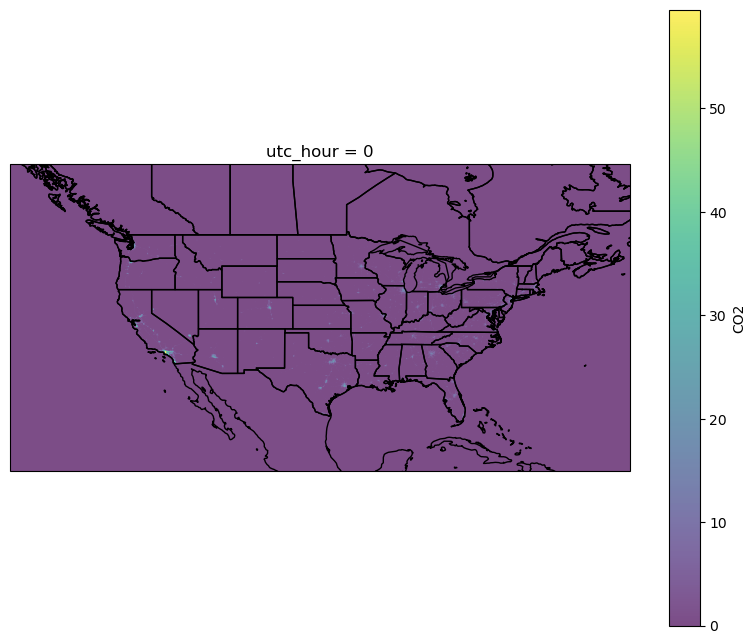

In [24]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
regridded_ds['CO2'][0,:,:].plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()